In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import math

## Import files

###### Sites Solar Data

In [2]:
files = "C:/Users/zhongj/Desktop/Task3_Data/Data_to_Use" #go to files direction
os.chdir(files)

In [3]:
df = pd.read_excel("Chosen_Sites_BTM_Daily_5am_9pm.xlsx")

In [4]:
dff = pd.read_excel("Chosen_Sites_BTM_Daily_10am_3pm.xlsx")

In [5]:
sites = list(df.columns)
sites.remove('DateTime')
sites.remove('Year')
sites.remove('Month')
sites.remove('Day')

In [6]:
df3= pd.read_excel("Data_recovery_rates_for_Chosen_Sites_2020.xlsx")
df3['Date'] = pd.to_datetime(df3['Date'])
df3["Month"] = df3['Date'].dt.month

In [7]:
def Data_to_Zero(df, df3):
    month = list(df['Month'].unique())
    for p in sites:
        for m in month:
            n = df3[df3['Month']== m][p].values[0]
            if  n<0.9:
                df[p].loc[(df['Month']== m)] = 0
    return df

In [8]:
df = Data_to_Zero(df,df3)

C:\Users\zhongj\Zhongj1\ZhongJ\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
dff = Data_to_Zero(dff,df3)

###### Sites information

In [10]:
df1= pd.read_excel("Sites_Information.xlsx")
df2 = df1[['Project_ID', 'Latitude','Longitude']]
df2.index = df2['Project_ID']

In [11]:
sites2 = list(map(int, sites))
df2 = df2.loc[sites2,:]
df2 = df2.reset_index(drop = True)

## Calculate distance between sites

In [12]:
def geodistance(lng1, lat1, lng2, lat2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2 ])
    dlon = lng2-lng1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    dis = 2*asin(sqrt(a))*6371*1000
    dis = round(dis/1000, 3)
    return dis

In [13]:
df_distance = pd.DataFrame(sites)
deglen = 110.25

for s in sites:
    lon = df2[df2['Project_ID']==int(s)]['Longitude'].values
    lat = df2[df2['Project_ID']==int(s)]['Latitude'].values
    distance = []
    for s2 in sites:
        lon2 = df2[df2['Project_ID']==int(s2)]['Longitude'].values
        lat2 = df2[df2['Project_ID']==int(s2)]['Latitude'].values
        
        d = geodistance(lon,lat, lon2, lat2)
        distance.append(d)
        
    df_distance['%s'%(s)] = distance

C:\Users\zhongj\Zhongj1\ZhongJ\lib\site-packages\ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app


In [14]:
df_distance.index = sites
del df_distance[0]

In [15]:
writer = pd.ExcelWriter(r'Distance_Between_Chosen_Sites.xlsx', 
                                engine = 'xlsxwriter')
df_distance.to_excel(writer)

writer.save()

## Seperate distances to 50 bins, every 10km is a bin

In [12]:
df_distance = pd.read_excel("Distance_Between_Chosen_Sites.xlsx")

In [13]:
df_distance['Unnamed: 0'] = df_distance['Unnamed: 0'].apply(lambda x:str(x))
df_distance.index = df_distance['Unnamed: 0']
del df_distance['Unnamed: 0']

In [14]:
bins = list(range(0,53))

def bin_func(x):
    for i in range(0, 53):
        if i*10<= x and x<(i+1)*10:
            return bins[i]

In [15]:
for p in sites:
    df_distance[p] = df_distance.apply(lambda x:bin_func(x[p]), axis=1)

### Put correlation between 2 sites into bins based on the distance between these two sites, and calculate the average of each bin

In [23]:
def correlation_changes(df, month, sites, bins):
    ## Calculate Correlations:
    cor_data = df.loc[(df['Month'] == month)]
    cor_data =  cor_data.loc[:, sites]

    correlation_mat = cor_data.corr()


    ## Put correlations to their bins:
    bin_list = [0]*len(bins)

    for s in sites:

        correlation_s = correlation_mat[s]

        for i, v in correlation_s.items():

            if i == s or math.isnan(v):
                pass
            else:
                bin_num =  df_distance[s][i]
                if type(bin_list[bin_num]) == int:
                    bin_list[bin_num] = []

                bin_list[bin_num].append(v)

    ## Calculate each bins average:
    bin_average = []
    count = []
    bin_name = []
    bin_name2 = []

    j = 0
    for i in bin_list:
        if type(i) == int:
            bin_list.remove(i)
            
        elif j<49:
            m = np.mean(i)
            
            bin_average.append(m)
            count.append(len(i)/2)
            
            km_begin = j*10
            km_end = (j+1)*10
            bin_name.append('%d-%dkm'%(km_begin,km_end))
            bin_name2.append((j+1)*10)
        j+=1
            
    return correlation_s, bin_name2, bin_average


In [105]:
files = "C:/Users/zhongj/Desktop/Task3_Results/Correlations" #go to files direction
os.chdir(files)

In [19]:
# colors = ['#0072BD', '#4DBEEE','#7E2F8E','#77AC30','#EDB120','#D95319', '#A2142F','#FF0000', '#00FF00','#FF00FF','#00FFFF','#0000FF']

# Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [101]:
colors = ['blue', 'green','red', '#DAA520']

ls = ['solid', (0,(5,2)), (0,(3,1,1,1,1,1))]

Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

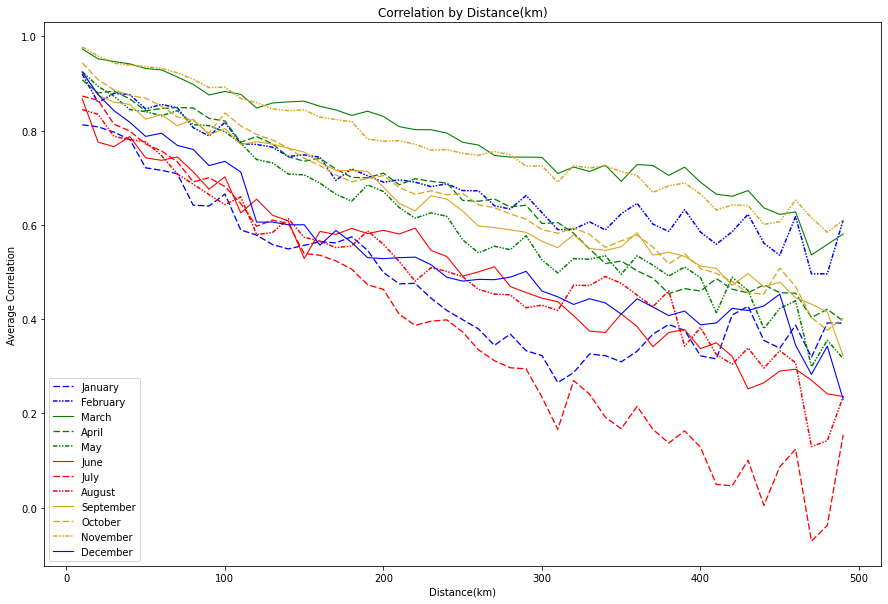

In [106]:
fig, ax = plt.subplots(1,1,figsize = (15,10))

for i in range(1,13):
    if i == 12 or i == 3 or i == 6 or i==9:
        j=0
        k=1.1
    elif i == 1 or i == 4 or i == 7 or i==10:
        j=1
        k=1.3
    else:
        j=2
        k=1.5
        
    if i == 12 or i == 1 or i == 2:
        _, bin_name2, bin_average =  correlation_changes(df, i, sites, bins)
        plt.plot(bin_name2, bin_average, linestyle = ls[j], label = Months[i-1], color = colors[0], linewidth = k)
    elif i == 3 or i == 4 or i == 5:
        _, bin_name2, bin_average =  correlation_changes(df, i, sites, bins)
        plt.plot(bin_name2, bin_average, linestyle = ls[j], label = Months[i-1], color = colors[1], linewidth = k)
    elif i == 6 or i == 7 or i == 8:
        _, bin_name2, bin_average =  correlation_changes(df, i, sites, bins)
        plt.plot(bin_name2, bin_average, linestyle = ls[j], label = Months[i-1], color = colors[2], linewidth = k)
    else:
        _, bin_name2, bin_average =  correlation_changes(df, i, sites, bins)
        plt.plot(bin_name2, bin_average, linestyle = ls[j], label = Months[i-1], color = colors[3], linewidth = k)
    
plt.legend()
plt.ylabel('Average Correlation')
plt.xlabel('Distance(km)')
plt.title('Correlation by Distance(km)')
plt.savefig('Correlation by distance(km)_5AM_9PM', bbox_inches="tight")
plt.show()